## Predict Recyclable or Organic using CNN

In [1]:
from keras.models import Model,load_model
from sklearn.datasets import load_files
import numpy as np

Using TensorFlow backend.


Loading the dataset and target labels

In [2]:
def getData(location):
    df = load_files(location)
    filenames = np.array(df['filenames'])
    output = np.array(df['target'])
    op_labels = np.array(df['target_names'])
    return filenames,output,op_labels

In [3]:
x_train, y_train, target_labels = getData('./DATASET/TRAIN')
print('No of training images : ' , x_train.shape[0])

No of training images :  22564


In [4]:
x_test, y_test, test_labels = getData('./DATASET/TEST')
print('No of test images : ', x_test.shape[0])

No of test images :  2513


Split into test and validation sets keeping 20% for validation

In [5]:
from sklearn.model_selection import train_test_split

x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size = 0.2,random_state = 1)

Transform image into array for easy processing refered from link https://pythonexamples.org/python-opencv-cv2-resize-image/

In [6]:
import cv2

def transfromImage(files):
    w, h = 100, 100
    imgArr = np.empty((files.shape[0], w, h, 3), dtype=np.uint8)
    for i,f in enumerate(files):
        data = cv2.imread(f) 
        result = cv2.resize(data, dsize=(w, h), interpolation=cv2.INTER_CUBIC)
        imgArr[i] = result
    return imgArr

In [7]:
x_train = np.array(transfromImage(x_train))
print('Training set shape : ',x_train.shape)

Training set shape :  (18051, 100, 100, 3)


In [8]:
x_valid = np.array(transfromImage(x_val))
print('Validation set shape : ',x_valid.shape)

Validation set shape :  (4513, 100, 100, 3)


In [9]:
x_test = np.array(transfromImage(x_test))
print('Test set shape : ',x_test.shape)

Test set shape :  (2513, 100, 100, 3)


Normalize image array

In [10]:
x_train = x_train.astype('float32')/255
x_valid = x_valid.astype('float32')/255
x_test = x_test.astype('float32')/255

In [11]:
y_train = y_train.reshape(y_train.shape[0],1)
y_test = y_test.reshape(y_test.shape[0],1)
y_val = y_val.reshape(y_val.shape[0],1)

Using ImageDataGenerator to expand the training dataset in order to improve the performance and ability of the model to generalize.
Code referred from https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [12]:
from keras.preprocessing.image import ImageDataGenerator

imgGen = ImageDataGenerator(
        featurewise_center=False,
        zoom_range = 0.1,
        width_shift_range=0.2,
        featurewise_std_normalization=False,
        samplewise_center=False,
        zca_whitening=False,
        height_shift_range=0.2,
        rotation_range=0,
        vertical_flip=False,
        horizontal_flip=False, 
        samplewise_std_normalization=False)

imgGen.fit(x_train)

Building the model. This model is inspired by the VGG architecture and was referrenced from https://jumba.me/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning/


The model was developed as follows, it consits of a Convolution layer followed by a Max- Pooling layer. Then there is another Convolution layer followed by a MaxPooling layer. The MaxPooling layer helps perform dimensionality reduction while still retaining all of the original information. This was then followed by a flatten layer whose job is to convert the multi-dimensional data into a 1-D vector for easier computation. The last two layers are fully connected layers which the last one having 2 nodes each corresponding to one of the classes in the dataset (recyclable , organic).

The earlier layers consisting of Convolutional And Pooling layers is often referred to as the feature extractor layers as they extract meaningful and focused information about an image. Pooling combines the outputs of clusters of neurons into a single neuron in the next layer. The last layers are usually the classification layer which are usually made up of fully connected networks which connect every neuron in one layer to every neuron in the next layer.

In [13]:
from keras.models import Sequential
from keras.layers import Conv2D, Activation,Dropout
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Flatten, Dense

model = Sequential()
model.add(Conv2D(32,kernel_size=(3, 3),kernel_initializer='he_normal',activation='relu',input_shape=(100,100,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16928)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)              

Define model callbacks and save best model

ModelCheckpoint enables us to save the model at a particualr stage in order to reduce the pain of going over the training process again

In [15]:
from keras.callbacks import ModelCheckpoint

saveModel = ModelCheckpoint(filepath = 'wasteClassificationConv.hdf5', verbose = 1, save_best_only = True)

Fit model and keep track of history of accuracy and loss

In [16]:
history = model.fit_generator(imgGen.flow(x_train, y_train, batch_size= 32), epochs = 10, callbacks = [saveModel], verbose=1, validation_data=(x_valid,y_val))

Epoch 1/10
565/565 [==============================] - 55s 97ms/step - loss: 0.5601 - accuracy: 0.7703 - val_loss: 0.4116 - val_accuracy: 0.8190

Epoch 00001: val_loss improved from inf to 0.41163, saving model to wasteClassificationConv.hdf5
Epoch 2/10
565/565 [==============================] - 51s 91ms/step - loss: 0.4362 - accuracy: 0.8055 - val_loss: 0.4041 - val_accuracy: 0.8176

Epoch 00002: val_loss improved from 0.41163 to 0.40415, saving model to wasteClassificationConv.hdf5
Epoch 3/10
565/565 [==============================] - 52s 93ms/step - loss: 0.4107 - accuracy: 0.8185 - val_loss: 0.3957 - val_accuracy: 0.8261

Epoch 00003: val_loss improved from 0.40415 to 0.39570, saving model to wasteClassificationConv.hdf5
Epoch 4/10
565/565 [==============================] - 52s 91ms/step - loss: 0.3911 - accuracy: 0.8339 - val_loss: 0.4010 - val_accuracy: 0.8187

Epoch 00004: val_loss did not improve from 0.39570
Epoch 5/10
565/565 [==============================] - 54s 96ms/step - 

Accracy vs Epoch Plot

Referenced from https://mohitatgithub.github.io/2018-03-28-MNIST-Image-Classification-with-CNN-&-Keras/

The model performed reasonably well giving an accuracy of about 85% on both train and test data.

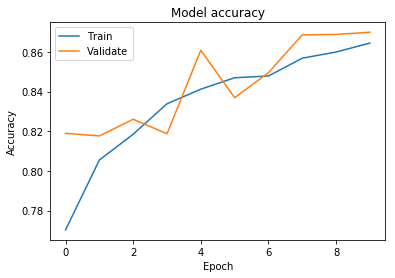

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()

Loss vs Epoch Plot

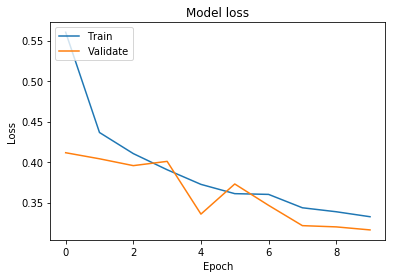

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()

Load the best model that was saved earlier

In [19]:
model = load_model('wasteClassificationConv.hdf5')
model.load_weights('wasteClassificationConv.hdf5')

Evaluate the model on test set

In [20]:
score = model.evaluate(x_test,y_test,verbose=0)
print('Accuracy :',score[1])

Accuracy : 0.8873856067657471


In [21]:
print('Loss :',score[0])

Loss : 0.2983203093060639


In [22]:
predictions = model.predict_classes(x_test)

Plotting the confusion matrix

Text(0.5, 0, 'Prediction')

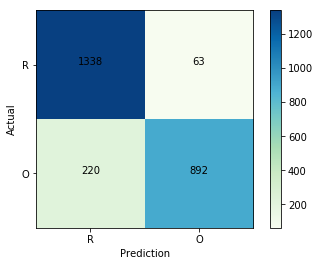

In [23]:
from sklearn.metrics import confusion_matrix
import itertools

matrix = confusion_matrix(y_test, predictions) 

plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.GnBu)
ticks = np.arange(2)
plt.xticks(ticks, ['R','O'])
plt.yticks(ticks, ['R','O'])
plt.colorbar()
thresh = matrix.max() / 2.
for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
    plt.text(j, i, matrix[i, j],horizontalalignment="center")
    
plt.ylabel('Actual')
plt.xlabel('Prediction')